# Masking sunglint from satellite imagery <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/Sandbox/sandbox/) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_s2am_ard_3](https://explorer.dea.ga.gov.au/ga_s2am_ard_3)

## Background
Sunglint is a phenomenon that occurs when sunlight reflects off the surface of water at a specific angle, creating a bright and often glare-like appearance on satellite imagery. 
Sunglint poses a significant problem for coastal remote sensing, often obscuring underlying features and affecting the overall quality of affected satellite imagery.
This can introduce high levels of noise into coastal remote sensing analyses, making it difficult to accurately observe and monitor coastal environments and processes.

Sunglint has a particularly large impact on data from the [Sentinel-2A and 2B satellites](../DEA_products/DEA_Sentinel2_Surface_Reflectance.ipynb), due to their wide field of view that can align with the angle of sunlight reflecting off the water's surface.
This makes it especially important to develop methods for removing the impact of sunglint on Sentinel-2 satellite data.

## Description
This notebook demonstrates how to use satellite and sun angle metadata from Digital Earth Australia to calculate glint angles which can be used to identify and remove potentially sunglint-affected pixels.

The notebook demonstrates how to:

1. Load a single sunglint-affected Sentinel-2 image
2. Calculate glint angles using the `dea_tools.coastal.glint_angle` function
3. Use glint angle data to mask out potentially sunglint-affected pixels
4. Load a timeseries of multiple Sentinel-2 images
5. Calculate glint angles for the entire timeseries, and apply as a sunglint mask
6. Calculate a sunglint-masked median composite


***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
import matplotlib.pyplot as plt

import datacube

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.datahandling import load_ard
from dea_tools.coastal import glint_angle
from dea_tools.plotting import rgb

### Connect to the datacube


In [2]:
dc = datacube.Datacube(app="Sunglint_masking")

## Loading satellite image

First, we will load a sunglint-affected Sentinel-2 image to demonstrate how sunglint can affect satellite imagery.

In addition to our standard red, green and blue satellite bands, we will some additional `oa_*` bands that contain data about the angles of the sun and the satellite sensor when the image was taken.
We will use this data later to identify and mask out potential sung-glinted pixels.

In [3]:
spectral_bands = [
    "nbart_red",
    "nbart_green",
    "nbart_blue",
]

sunglint_bands = [
    "oa_solar_zenith",
    "oa_solar_azimuth",
    "oa_satellite_azimuth",
    "oa_satellite_view",
]


ds = load_ard(
    dc=dc,
    products=["ga_s2bm_ard_3"],
    time="2020-10-14",
    x=(126.30, 128.14),
    y=(-13.65, -14.20),
    measurements=spectral_bands + sunglint_bands,
    group_by="solar_day",
    resampling="average",
    resolution=(-100, 100),
    cloud_mask="s2cloudless",
)

Finding datasets
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps


Now we can plot our result.

Look at the image below, comparing the dark water in the west (left) of the image to the water on the eastern side (right).
As we move towards the eastern side of the image, we can see the water surface growing brighter and washed out.
These bright pixels are the result of sunglint: sunlight reflecting off the surface of the water directly towards the satellite sensor.

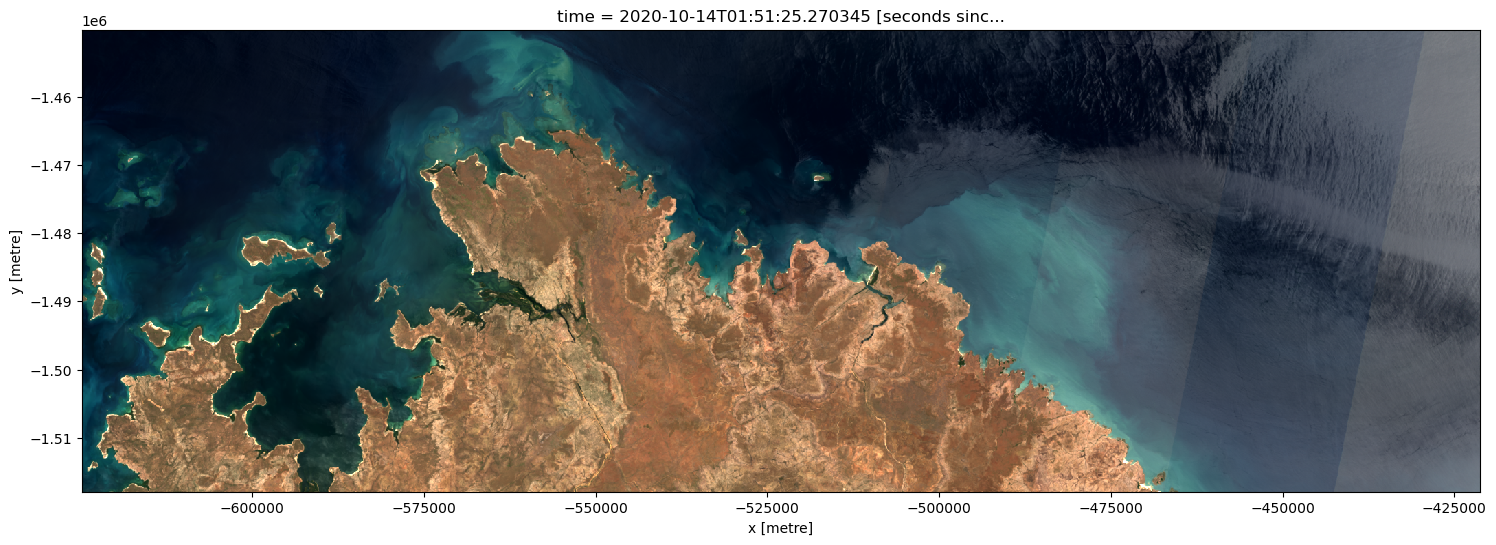

In [4]:
rgb(ds, vmin=50, vmax=1700)

### Calculating glint angles
Glint angles represent how closely the angle of the sun's reflection of the water surface matches up with the angle the satellite sensor is looking. 
A small angle indicates that sunlight is bouncing directly towards the satellite sensor, which can result in sunglint-affected pixels. 
Large angles however suggest that reflections are likely to be reflecting away from the satellite sensor, and therefore not affecting the imagery.

Glint angles can therefore be used to identify pixels that are most likely to be affected by sunglint. 
We can calculate glint angles for every pixel in a dataset using the `glint_angle` function below. 
If we plot sunglint for our image, we can see it has relatively large glint angles in the west (indicating low likelihood of sunglint), but lower angles in the east (indicating higher likelihood of sunglint).
This matches up with what we saw in the imagery above.

> **Note:** The `glint_angle` function is inspired by code from this [Medium post](https://towardsdatascience.com/how-to-implement-sunglint-detection-for-sentinel-2-images-in-python-using-metadata-info-155e683d50), and [Giglio et al. 2003](https://doi.org/10.1016/S0034-4257(03)00184-6).

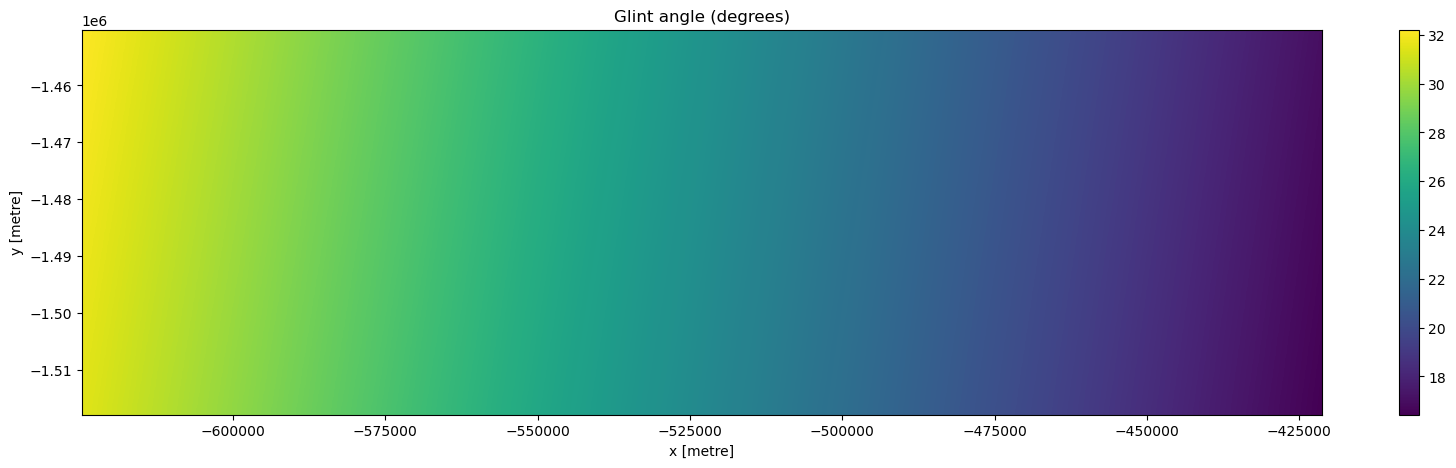

In [5]:
# Calculate glint angle using sensor and solar geometry
glint_array = glint_angle(
    solar_azimuth=ds.oa_solar_azimuth,
    solar_zenith=ds.oa_solar_zenith,
    view_azimuth=ds.oa_satellite_azimuth,
    view_zenith=ds.oa_satellite_view,
)

# Plot result
glint_array.plot(size=5, aspect=4)
plt.title("Glint angle (degrees)");

### Applying a sunglint mask
Now that we have calculated glint angles for each pixel in our image, we can use this information to mask out potentially sunglinted pixels.

There is no "correct" glint angle threshold to use to identify sunglint; here we use 20 degrees which is often a good starting point.
In the image below, any pixel with a glint angle of less than 20 degrees is set to nodata (`NaN`), removing it from our image:

/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


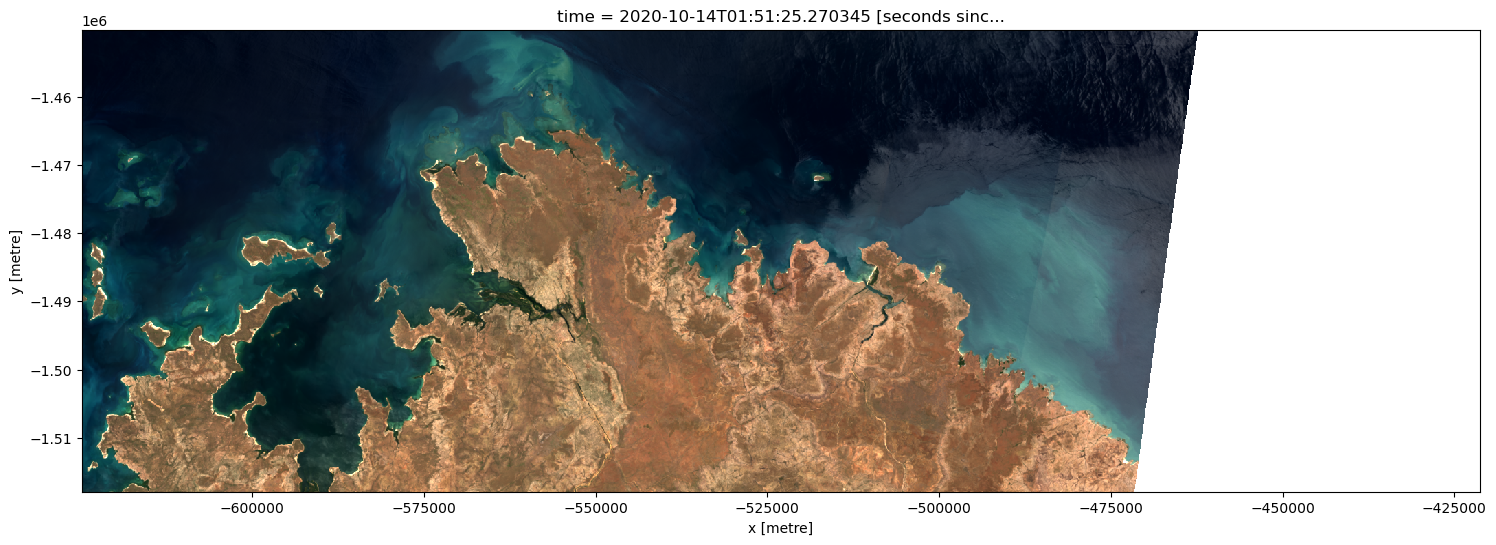

In [6]:
# Apply a glint mask using a 20 degree glint angle threshold
glint_mask = glint_array > 20
ds_glint_masked = ds.where(glint_mask)

# Plot our sunglint masked data
rgb(ds_glint_masked, vmin=50, vmax=1700)

You may notice a small amount of sunglint remains in the east of the image.

The exact choice of glint angle threshold will depend on your application, and how you weigh up removing all possible sunglint vs. losing some valid data.
In the example below, we apply a stricter glint threshold of 25 degrees.
This removes more glint, but leaves us with less data overall:

/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


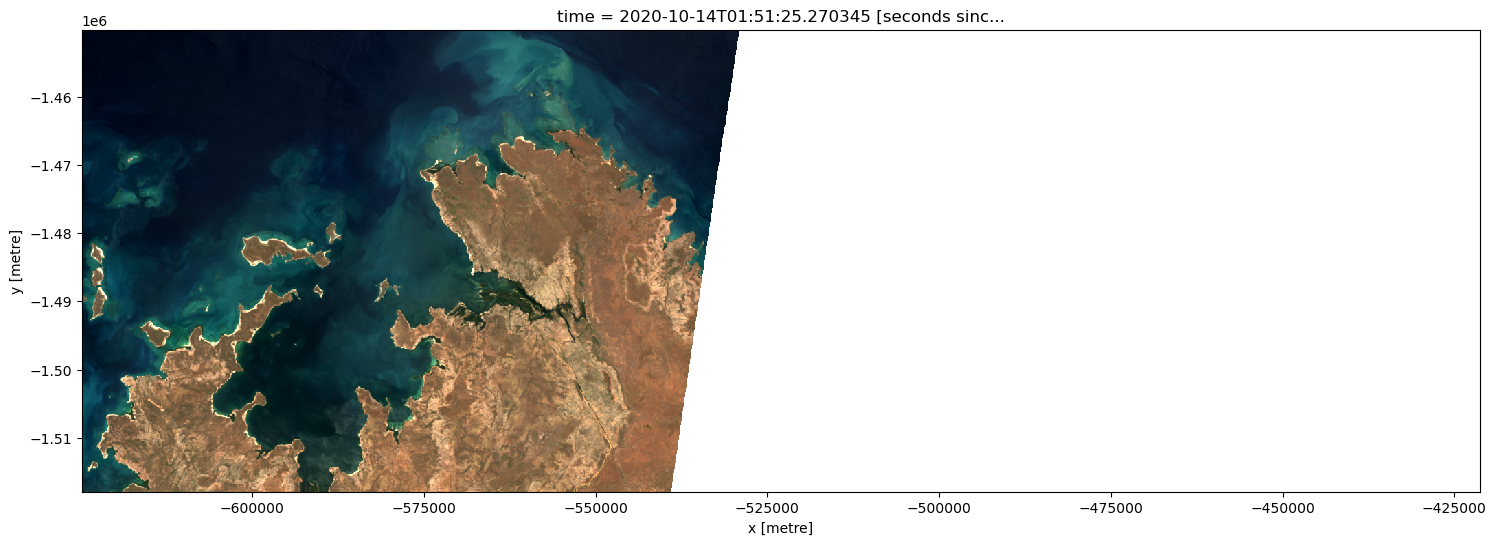

In [7]:
# Apply a glint mask using a 25 degree glint angle threshold
glint_mask = glint_array > 25
ds_glint_masked = ds.where(glint_mask)

# Plot our sunglint masked data
rgb(ds_glint_masked, vmin=50, vmax=1700)

## Masking sunglint from multiple images at once
For larger analyses, we may want to remove sunglint from our entire satellite data timeseries. 
For example, below we have loaded three months of mostly cloud-free Sentinel-2A data:

In [8]:
ds = load_ard(
    dc=dc,
    products=["ga_s2bm_ard_3"],
    time=("2020-08-10", "2020-11-10"),
    x=(127.00, 128.14),
    y=(-13.65, -14.20),
    measurements=spectral_bands + sunglint_bands,
    group_by="solar_day",
    resolution=(-200, 200),
    min_gooddata=0.8,
    cloud_mask="s2cloudless",
)

Finding datasets
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 6 out of 9 time steps with at least 80.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 6 time steps


If we plot this data, we can see that the most recent three images are strongly affected by sunglint:

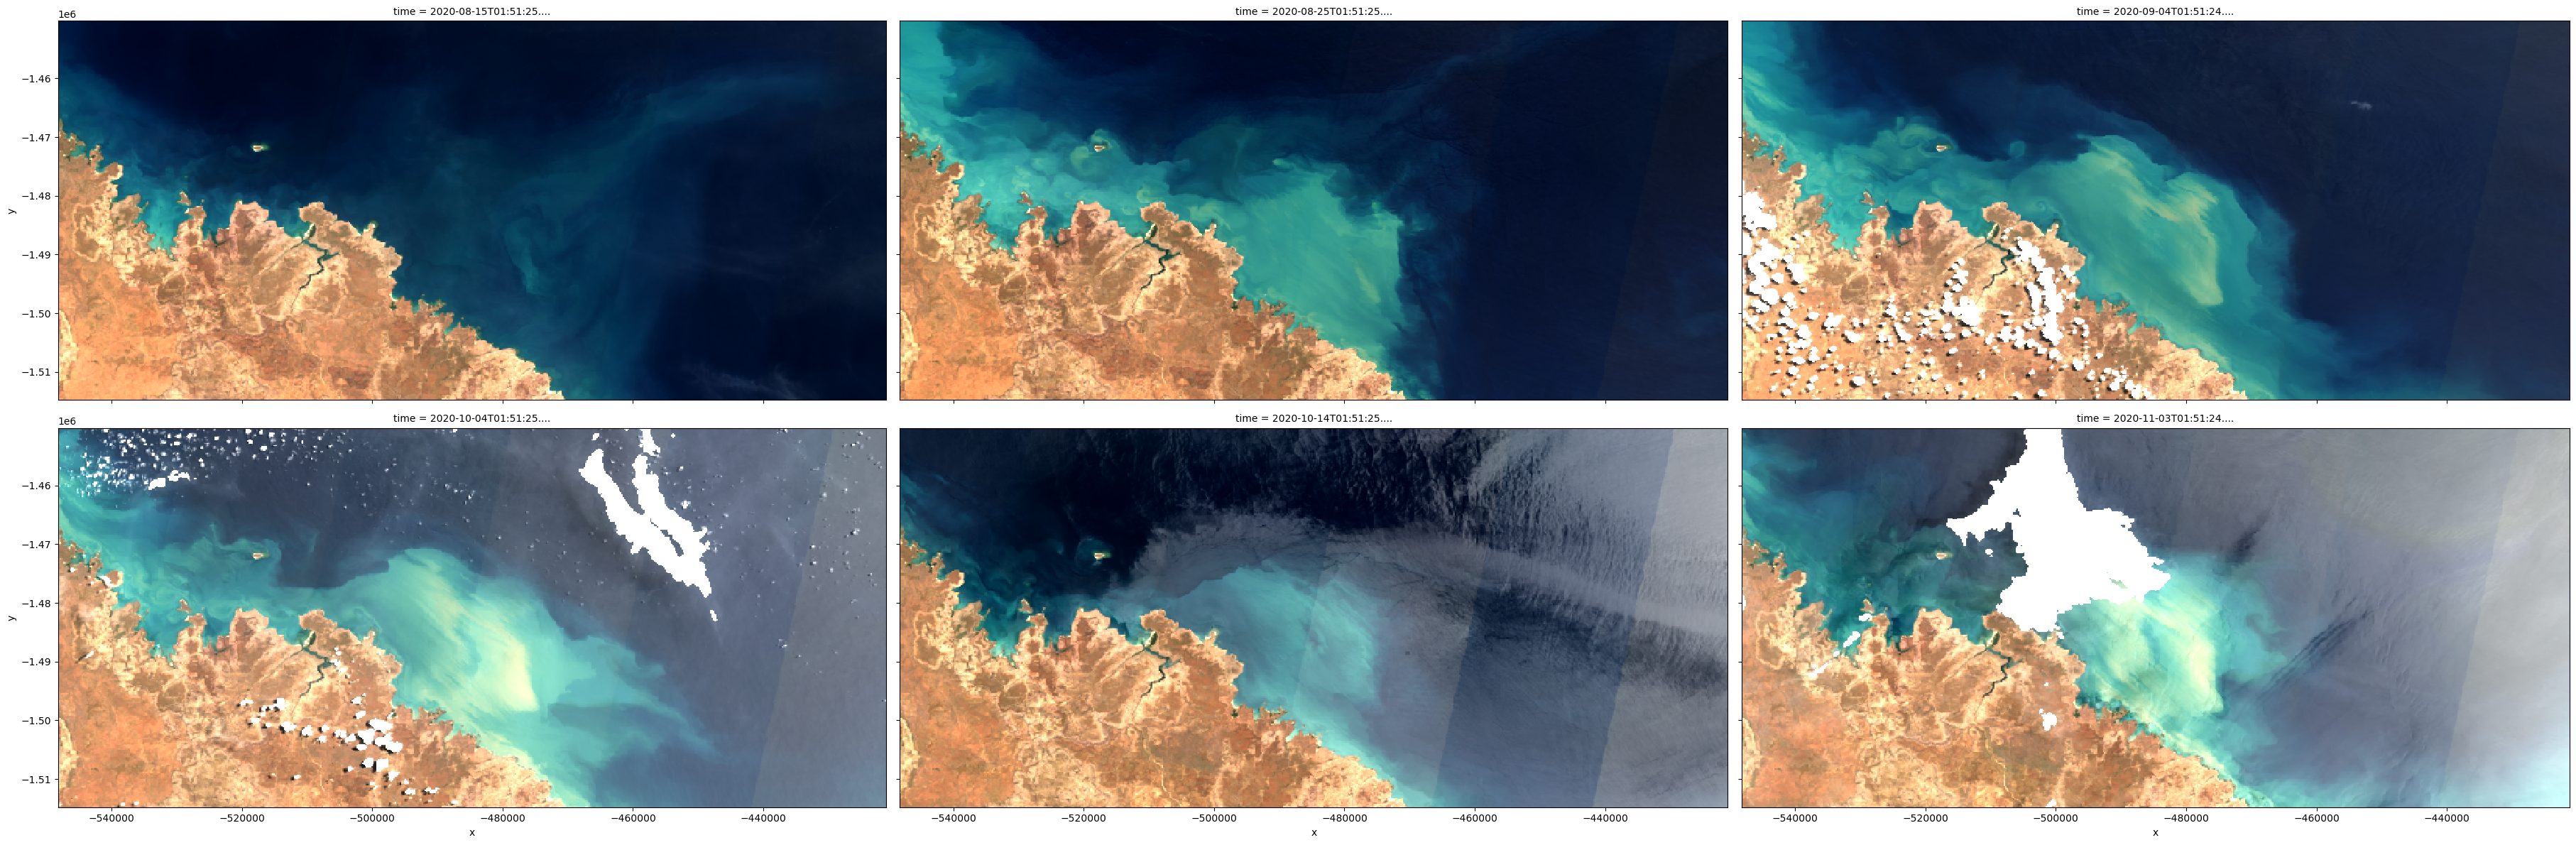

In [9]:
rgb(ds, col="time", col_wrap=3)

### Calculating glint angles for multiple images
The `glint_angle` will automatically calculate glint angles for every timestep in a satellite dataset. 
We can simply run it on our entire satellite dataset in the same way we applied it to an individual image.

If we plot our results, we can see that the most recent three images have lower glint angles, indicating higher likelihood of sunglint (matching what we can see in the imagery above).

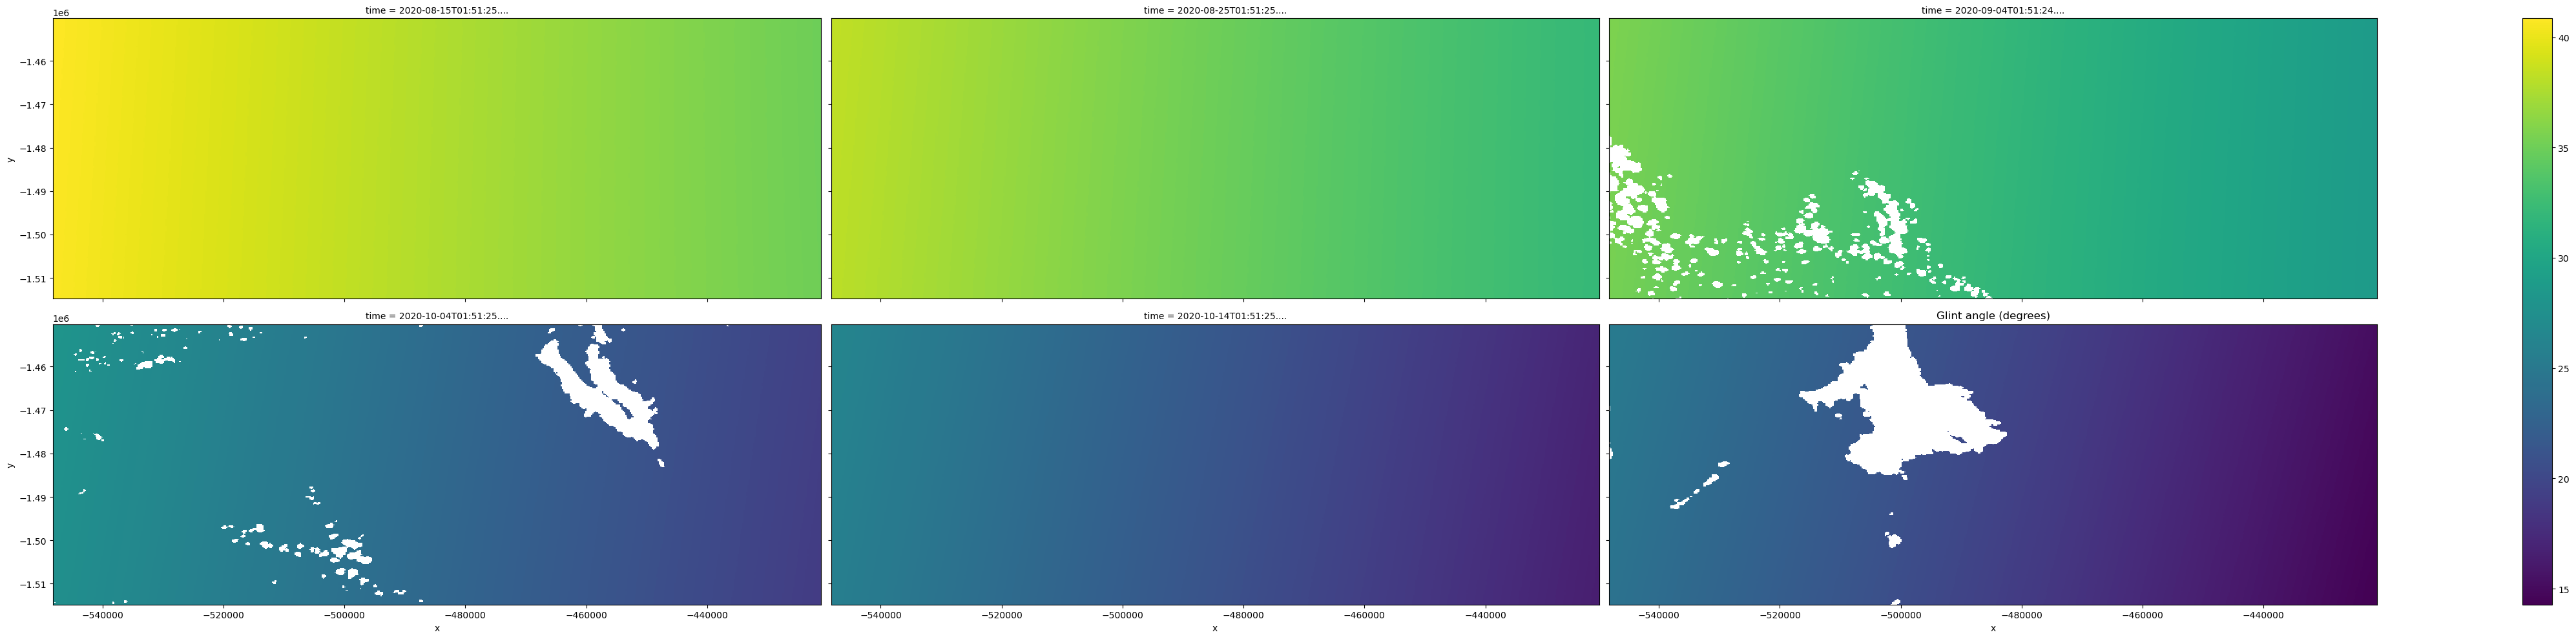

In [10]:
# Calculate glint angle using sensor and solar geometry
glint_array = glint_angle(
    solar_azimuth=ds.oa_solar_azimuth,
    solar_zenith=ds.oa_solar_zenith,
    view_azimuth=ds.oa_satellite_azimuth,
    view_zenith=ds.oa_satellite_view,
)

# Plot result
glint_array.plot.imshow(size=5, aspect=3, col="time", col_wrap=3)
plt.title("Glint angle (degrees)");

### Applying a sunglint mask to multiple images
We can use these sunglint angles as a mask that we can apply to our entire dataset. 
Here we try an aggressive 25 degree filter, which will remove any pixels with glint angles less than 25 degrees from our data.

After masking, we can see that most sunglint affected pixels have been removed:

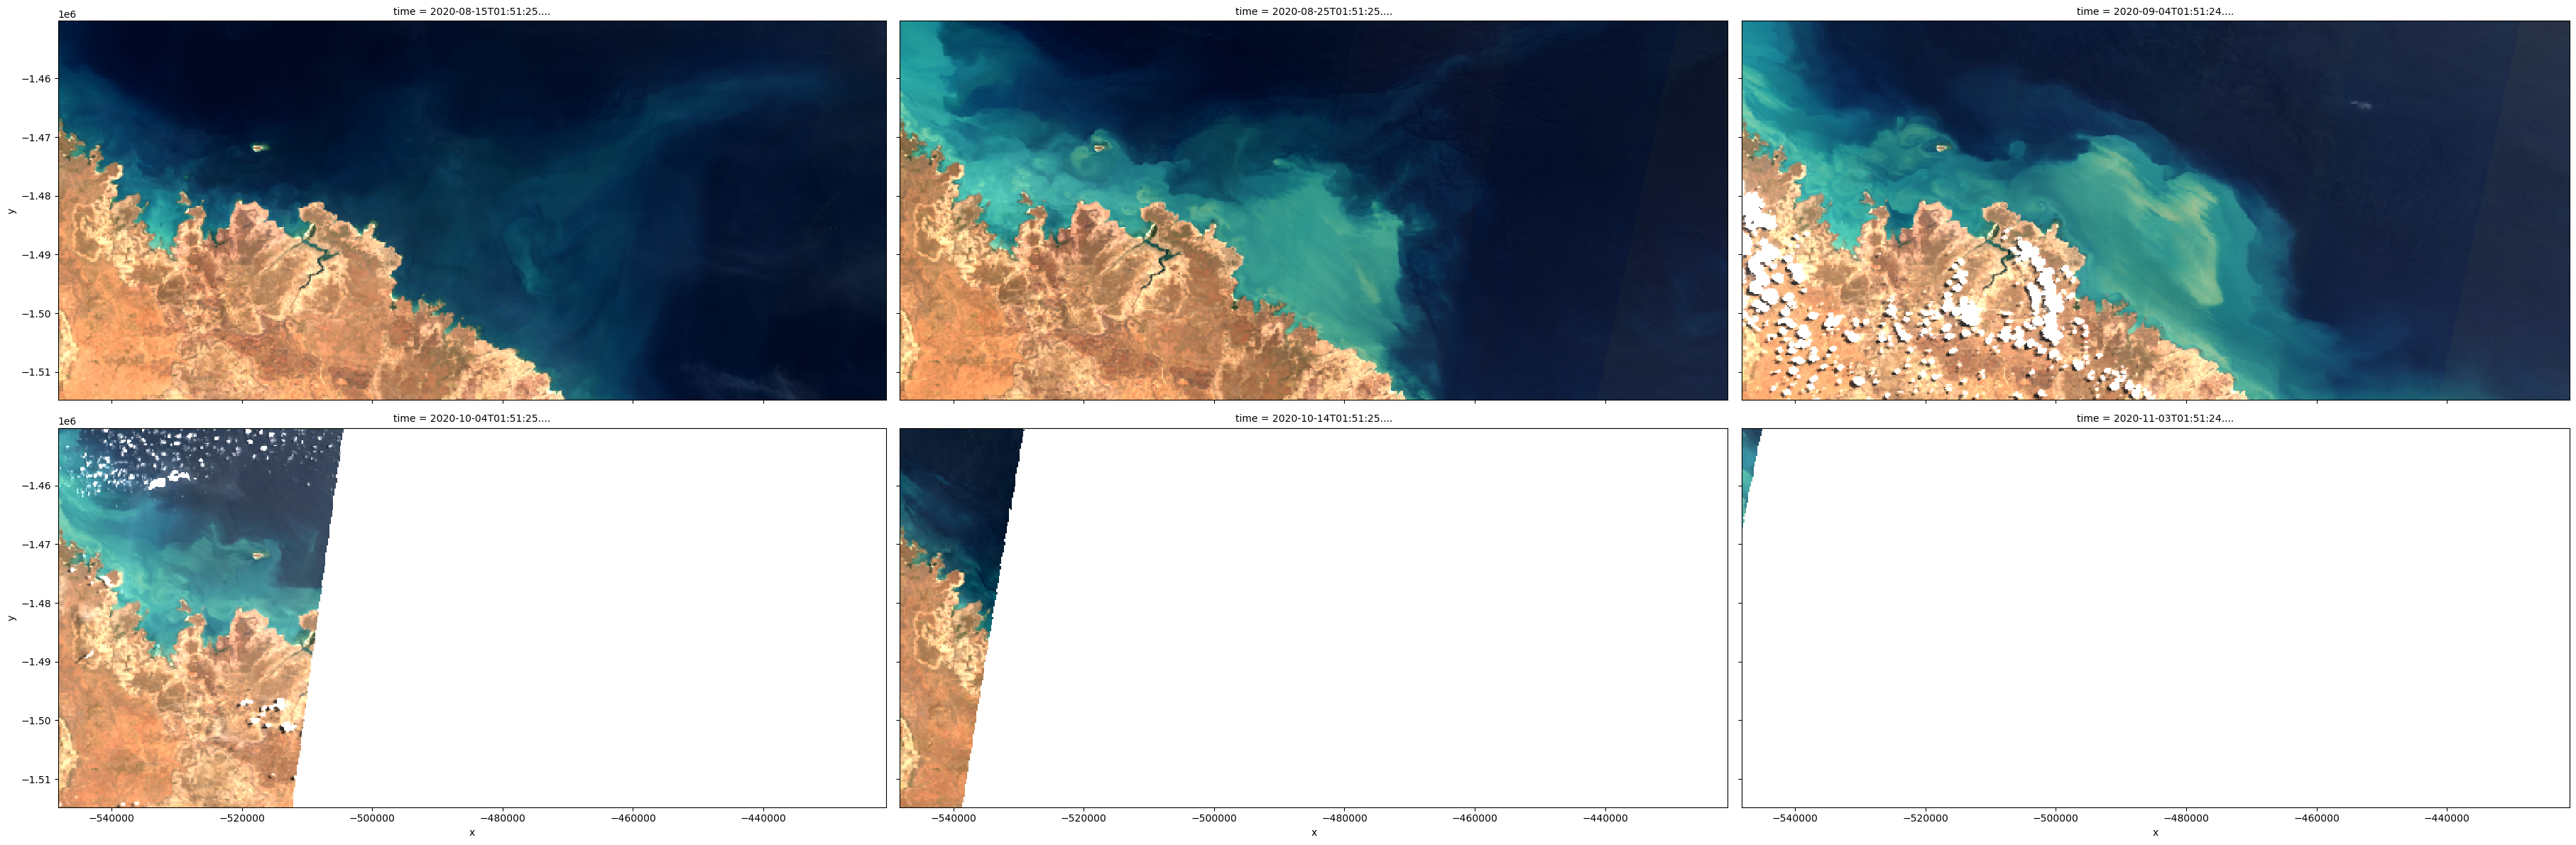

In [11]:
# Apply sunglint mask
ds_sunglint_masked = ds.where(glint_array > 25)

# Plot
rgb(ds_sunglint_masked, col="time", col_wrap=3)

### Creating sunglint-free composites
A common remote sensing use case is combining multiple images into a single less noisy composite.

Sunglint can cause issues in this workflow, reducing the quality of our outputs.
For example, if we try to take a median composite of our imagery above, we can see that the output image is affected by sunglint along the east of the image:

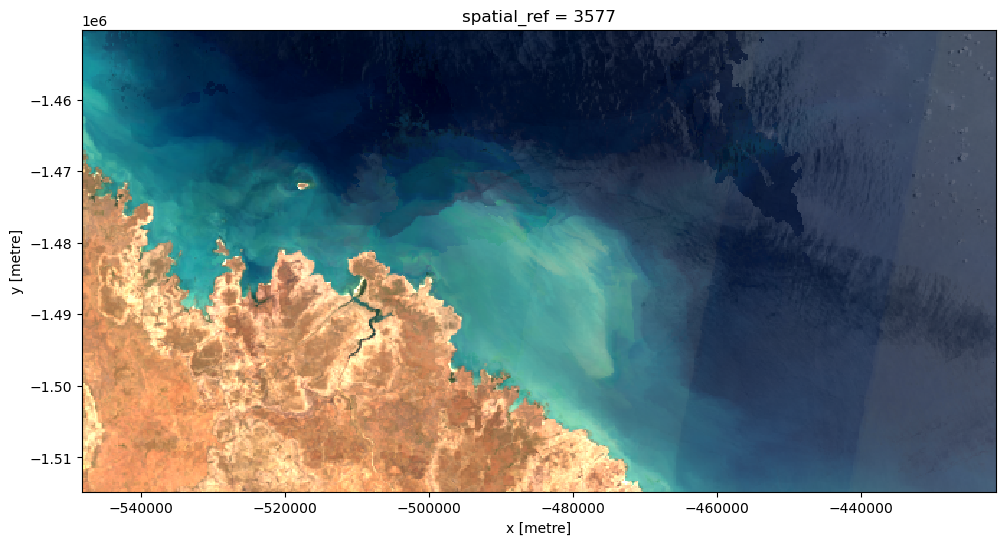

In [12]:
# Plot median composite, no sunglint masking
rgb(ds.median(dim="time"))

However, by generating our composite image after first applying our sunglint filter, we can get much cleaner, more useful results!

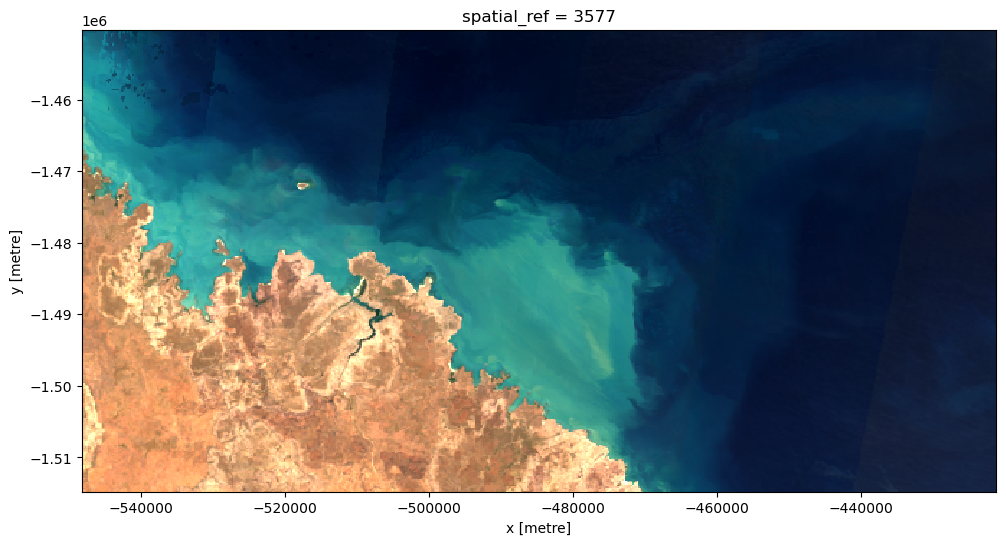

In [13]:
# Plot sunglint-masked median composite
rgb(ds_sunglint_masked.median(dim="time"))

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.15


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex/) -->